# Danish age-corrected murder rates 1980-2022

### Table of contents:
1. Introduction

2. Convictions as proxy for incidence

3. Age-corrected murder rates

In [2]:
%pip install git+https://github.com/elben10/pydst

  Cloning https://github.com/elben10/pydst to c:\users\juliu\appdata\local\temp\pip-req-build-nrxtrsi1
  Resolved https://github.com/elben10/pydst to commit bb347560a1b3c17684fda072c829658da38f5a72
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  Running command git clone --filter=blob:none --quiet https://github.com/elben10/pydst 'C:\Users\juliu\AppData\Local\Temp\pip-req-build-nrxtrsi1'


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pydst
import statsmodels.api as sm
import dataproject as dp
%load_ext autoreload
%autoreload 2

### 1 Introduction

From time to time articles appear in Danish media discussing the observed reductions in crime rates since the mid 90's. A possible confounder rarely discussed is the concurrent changes in the age structure of Danish society. Since the vast majority of violent ('personfarlig') crime is commited by young men in their teens to their early twenties, this is potentially a serious confounder. In this short project, we examine how the age-corrected murder rate ('manddrab') has changed over time from 1980 to 2022. 

Why murder rate? Since both social and judicial definitions of violent crime have evolved over time, it is difficult to argue that increases in e.g. reported assaults or rapes directly reflect increases in objective incidence rates. Murder is in comparison a far more fixed entity, requiring a dead body and evidence of intentional homicide. 

Utilizing data from Danmarks Statistik on murder convictions and population age structure from 1980 to 2022, we compute age-specific murder rates for each year. We then find the specific age structure of the year 1980, expressed in fractions. These 1980 population age fractions are then scaled onto the age-specific murder rates in all years, producing the age-corrected murder rates that when summed for a given year reflect *what the murder rate would have been in a given year, had the population age structure in the given year been identical to the age structure of 1980*.  


### 2 Convictions as proxy for incidence

Given that we only have data on the characteristics of those convicted for murder, rather than on those who have perpetrated murder, there remains the issue of whether convictions are a sufficient proxy for incidence. Since we are interested in the development over time of the murder rate, confounders would lie in developments in the relationship over time between the conviction rate and the incidence rate, which may render the conviction rate a bad proxy for the incidence rate. As an example, police might have increased clearance rates over the period in question, which would bias results upwards (an appearance of more murder over time). For this reason we plot the evolution in the number of murders minus the number of convictions for murder over the period in question.

#### 2.1. Importing, exploring, cleaning data for murder incidence and convictions

In [3]:
Dst = pydst.Dst(lang='da') #Using API from Danmarks Statistik

#Extracting data on murder convictions
variables = {'KØN':['M','K'], 'ALDER':['*'], 'AFGØRELSE':['1','2','511','516','517','518'],'Tid':['*'], 'OVERTRÆD':['1230']} 
råstraf = Dst.get_data(table_id = 'STRAF40', variables=variables)
råstraf.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)

straf_sum = råstraf.groupby(['ALDER', 'TID']).sum(numeric_only=1) #Summing all the pertinent (guilty) judicial rulings into one number for each year and age category
straf = pd.pivot_table(straf_sum, index = ['ALDER'], columns = ['TID']) #Pivoting table into a more useful format
straf2 = straf.convert_dtypes() #Converting object types to integers to save the world
straf3 = straf2.rename(columns={'INDHOLD':' Table 1 - Danish murder convictions by age category 1980-2022'})
display(straf3)

Table 1 - Danish murder convictions by age category 1980-2022  \
TID                                                                        1980   
ALDER                                                                             
15 år                                                          <NA>               
16 år                                                          <NA>               
17 år                                                          <NA>               
18 år                                                             1               
19 år                                                          <NA>               
20 år                                                          <NA>               
21 år                                                             2               
22 år                                                             1               
23 år                                                          <NA>               
24 år                                                             1               
25-29 år                                                          6               
30-39 år                                                          9               
40-49 år                                                          2               
50-59 år                                                          3               
60-69 år                                                          1               
70-79 år                                                          1               
80 år og derover                                               <NA>               
Alder i alt                                                      27               

                                                                        ...  \
TID               1981  1982  1983  1984  1985  1986  1987  1988  1989  ...   
ALDER                                                                   ...   
15 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
16 år                1  <NA>     1     1  <NA>     1  <NA>  <NA>  <NA>  ...   
17 år                1  <NA>  <NA>  <NA>  <NA>  <NA>     1  <NA>  <NA>  ...   
18 år             <NA>  <NA>     1     1  <NA>     1  <NA>     1  <NA>  ...   
19 år                2     2     1     1  <NA>     2     2  <NA>     1  ...   
20 år                2     1     2  <NA>     2     1  <NA>     1  <NA>  ...   
21 år                2     2     1  <NA>  <NA>     2     1  <NA>  <NA>  ...   
22 år                1  <NA>     1  <NA>  <NA>     3  <NA>     3     1  ...   
23 år                4  <NA>     1  <NA>     1  <NA>     1     1     4  ...   
24 år             <NA>     2     2     2     2  <NA>     1     1     2  ...   
25-29 år             4     6    10     6     9     4    10     6     4  ...   
30-39 år             7    12     9    10     8    13     8    11    12  ...   
40-49 år             4     5     6     9     4    11     3     5     5  ...   
50-59 år             2     3     4     2     4     2     4     1     2  ...   
60-69 år             2  <NA>     1     2  <NA>     2     3  <NA>     1  ...   
70-79 år          <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
80 år og derover  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  ...   
Alder i alt         32    33    40    34    30    42    34    30    32  ...   

                                                                              
TID               2013  2014  2015  2016  2017  2018  2019  2020  2021  2022  
ALDER                                                                         
15 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
16 år             <NA>  <NA>     2     1  <NA>  <NA>  <NA>     1     1  <NA>  
17 år                2     1  <NA>     1  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  
18 år             <NA>  <NA>  <NA>  <NA>  <NA>  <NA>  <NA>     1     1     1  
19 år                1  <NA>  <NA>     1  <NA>     1     1   

In [4]:
#Extracting data on murder incidence
variables2 = {'ANMSIGT':['ANM'],'OVERTRÆD':['1230'], 'Tid':['*']}
anmeldte = Dst.get_data(table_id = 'STRAF20', variables=variables2)
del anmeldte['OVERTRÆD']
del anmeldte['ANMSIGT']
anmeldte = anmeldte.rename(columns={"INDHOLD":"Antal"})
anmeldte = pd.pivot_table(anmeldte, columns='TID')
anmeldte.style.set_caption('Table 2 - Murder incidence by year, 1995-2022')


TID,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Antal,60,69,88,49,52,58,52,48,66,44,53,29,45,53,56,49,49,43,41,59,46,49,54,52,48,49,39,55


#### 2.2 Visualizing the proxy relationship

In [5]:
straf_proxy = straf2.loc['Alder i alt'] #Extracting the total conviction rate for each year
straf_proxy = straf_proxy.loc['INDHOLD', 1995:2022] #Limiting the data selection to the years 1995-2022 due to data limitations in the incidence data
anmeldte_proxy = anmeldte.loc['Antal']

 
stationaritet = (anmeldte_proxy-straf_proxy).astype(int) #the difference between number convicted and incidence, forcing object type to integer 
display(stationaritet)


         TID 
INDHOLD  1995    20
         1996    22
         1997    47
         1998     8
         1999    19
         2000    26
         2001    16
         2002    17
         2003    35
         2004    16
         2005    21
         2006     2
         2007    27
         2008    31
         2009    21
         2010    -5
         2011    23
         2012     9
         2013    17
         2014    37
         2015    14
         2016    30
         2017    23
         2018    25
         2019    29
         2020    10
         2021    12
         2022    31
dtype: int32

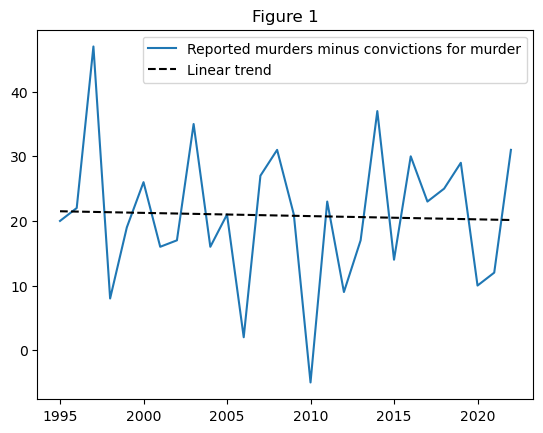

Linear trend:  
-0.05008 x + 121.4


In [6]:
tid_proxy = range(1995,2023) # creating the x-axis
z = np.polyfit(tid_proxy, stationaritet, 1) # fitting trend line
p = np.poly1d(z)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tid_proxy, stationaritet, label='Reported murders minus convictions for murder')
ax.plot(tid_proxy, p(tid_proxy), color='black', linestyle='--', label='Linear trend')
plt.title('Figure 1')
plt.legend()
plt.show()
print(f'Linear trend: {p}')

The relationship appears stationary, perhaps with a very slight downwards trend. Convictions seem to be a good proxy for incidence for our purpose. 

### 3 Age-corrected murder rates

#### 3.1 Importing, exploring, and cleaning data on population structure

In [7]:
#Selektion af værdier for variable 
variables_folk = {'KØN':['1','2'],'ALDER':['*'], 'Tid':[str(x) for x in range(1980, 2023)]}



befolkning = Dst.get_data(table_id = 'BEFOLK1', variables=variables_folk)
befolkning.sort_values(by=['KØN', 'ALDER', 'TID'], inplace=True)


del befolkning['CIVILSTAND']

#gør variablen numerisk (15 år bliver til 15)

def to_int(x):
    if x == '99 år og derover':
        return 99   #gør alle over 99 til 99 år, til stor frustration for Ældresagen
    elif x == 'Alder i alt':
        return None 
    else:
        return int(x.split(' ')[0])

befolkning['ALDER'] = befolkning['ALDER'].apply(to_int)

befolkning = befolkning.dropna(subset=['ALDER'])

#Laver aldersintervaller, der matcher datasættet straf2
befolkning['aldersinterval'] = befolkning.ALDER.apply(lambda x: dp.age_buckets2(x))
del befolkning['ALDER']

bef_sum = befolkning.groupby(['aldersinterval', 'TID']).sum(numeric_only=1) #summer over de variable vi har brug for

bef = pd.pivot_table(bef_sum, index = ['aldersinterval'], columns = ['TID']) #Pivoterer 

bef.columns = bef.columns.droplevel() #Fjerner irriterende titel 

samletalder = bef_sum.groupby(['TID']).sum(numeric_only=1) #Udregner samlet population for hvert år
samletalder = pd.pivot_table(samletalder, columns = ['TID'])

newv = pd.concat([bef, samletalder], axis=0, join='inner') #føjer samlet population til tabel
newv = newv.rename(index={'INDHOLD':'Alder i alt'})

newv.style.set_caption('Table 3 - Population distribution 1980-2022')


TID,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
14 år og under,1081431,1054870,1020314,992303,969375,950715,935130,917954,901284,889304,880557,873630,874945,882563,889250,900916,919680,936947,952188,967643,981148,994513,1005203,1013046,1017578,1018146,1015879,1014153,1009917,1008086,1001318,995087,986458,977596,968670,962647,960274,961568,960570,957470,953118,948784,945831
15 år,82114,84428,87253,80577,73967,71115,71062,75109,75463,71950,71760,72774,66316,63158,63449,60842,59381,55422,55325,53693,54857,57039,58695,59400,62290,64810,66934,67397,70522,70083,72546,72310,69887,69593,68174,68119,69127,67555,66614,67512,67768,67877,69009
16 år,81265,82317,84493,87333,80743,74189,71410,71374,75402,75693,72139,71982,72992,66604,63371,63674,61332,59661,55628,55612,53909,55092,57368,58961,59663,62451,64930,67088,67595,70993,70482,73020,72740,70278,70073,68822,68772,69839,68201,67142,67948,68246,68420
17 år,76616,81289,82329,84496,87411,80859,74424,71753,71565,75430,75748,72311,72171,73199,66806,63598,64133,61763,60017,56028,56001,54377,55660,57896,59431,60082,62823,65272,67450,68043,71164,70615,73204,72834,70507,70306,69287,69260,70115,68260,67304,68088,68469
18 år,75478,76817,81383,82488,84612,87606,81104,74925,72072,71691,75610,76025,72670,72701,73604,67087,64140,64551,62015,60266,56258,56166,54550,55763,57917,59419,60082,62838,65339,67633,68151,71376,70840,73491,73255,70973,71131,70008,69781,70566,68639,67674,68674
19 år,75330,75424,76532,81138,82224,84440,87401,81301,74846,71571,71373,75228,75683,72239,72247,73216,67118,64110,64472,61971,60308,56297,56279,54746,55793,57820,59444,60226,63357,66175,68585,69145,72454,72028,74737,74684,72647,72688,71269,70935,71623,69581,69151
20 år,73218,75333,75364,76568,81303,82523,84940,88033,81564,74744,71870,71740,75683,76205,72760,72756,73907,67713,64599,64867,62490,60651,56751,56808,55153,56229,58521,60343,61689,64794,67428,69776,70821,73946,73470,76210,76989,74572,74585,72820,72131,72666,71267
21 år,74043,73194,75281,75388,76709,81497,82968,85488,88291,81491,75061,72338,72327,76317,76924,73418,73744,74718,68402,65362,65704,63238,61593,57659,57655,56176,57324,59774,62081,63414,66525,68877,71793,72131,75528,74883,78470,78567,76294,75806,73901,72840,74538
22 år,74277,73846,73065,75254,75565,76871,81942,83526,85630,88133,81560,75440,72587,72811,76699,77293,74122,74244,75239,69094,66072,66342,63981,62319,58340,58419,57175,58392,61318,63704,64575,67544,70043,72597,73075,76460,76602,79900,79720,77306,76462,74517,74686
23 år,75190,74111,73732,73005,75258,75610,77430,82438,83640,85461,88189,81801,75791,72863,73188,76982,77911,74641,74748,75689,69520,66431,66898,64408,62695,58756,59098,58024,59737,62761,64683,65672,68614,71337,73849,74419,78420,78399,81298,80841,78029,77321,76345


#### 3.2 Calculating murder rate

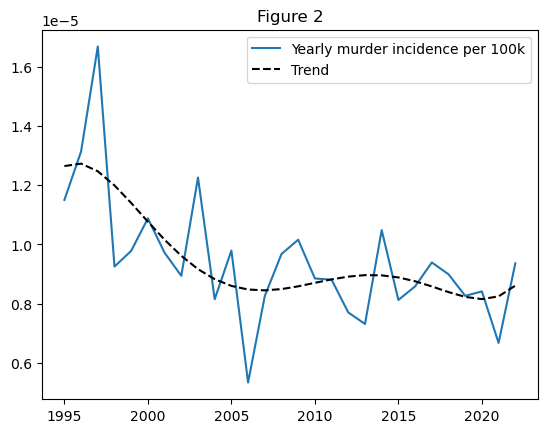

In [8]:
#3.2.1 Illustrating the murder rate 1995-2022
z3 = np.polyfit(tid_proxy, anmeldte.loc['Antal',:].div(newv.loc['Alder i alt',1995:2023]), 5) # fitting trend line
p3 = np.poly1d(z3)
fig3 = plt.figure()
ax3 = fig3.add_subplot(1,1,1)
ax3.plot(tid_proxy, anmeldte.loc['Antal',:].div(newv.loc['Alder i alt',1995:2023]), label='Yearly murder incidence per 100k')
ax3.plot(tid_proxy, p3(tid_proxy), color='black', linestyle='--', label='Trend')
plt.title('Figure 2')
plt.legend()
plt.show()

The murder rate appears to have dropped since the mid 90's. 

In [9]:
#3.2.2 Illustrating the murder conviction rate 1980-2022
mordrate = straf2.div(newv)*100000 #Mord pr 100.000 indbyggere
mordrate.style.set_caption('Table 4 - Murder convictions per capita 1980-2022')


mordrateialt = mordrate.loc['Alder i alt',:].astype(float)
display(mordrateialt)

         TID 
INDHOLD  1980    0.527131
         1981    0.624513
         1982    0.644638
         1983    0.781790
         1984    0.665085
         1985    0.586957
         1986    0.820910
         1987    0.663441
         1988    0.584880
         1989    0.623809
         1990    0.642597
         1991    0.505201
         1992    0.774875
         1993    0.752807
         1994    0.596539
         1995    0.766913
         1996    0.895063
         1997    0.777233
         1998    0.774336
         1999    0.621051
         2000    0.600373
         2001    0.672996
         2002    0.577458
         2003    0.575833
         2004    0.518745
         2005    0.591344
         2006    0.497470
         2007    0.330452
         2008    0.401768
         2009    0.635041
         2010    0.975656
         2011    0.467573
         2012    0.609263
         2013    0.428370
         2014    0.390956
         2015    0.565399
         2016    0.332910
         2017    0.53924

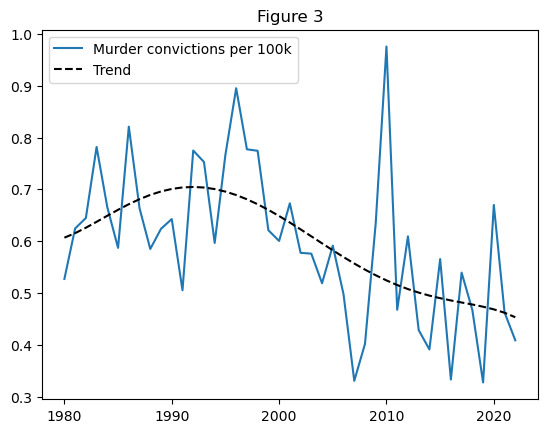

In [10]:
tid1 = range(1980, 2023, 1)
z1 = np.polyfit(tid1, mordrateialt, 5) # fitting trend line
p1 = np.poly1d(z1)
fig1 = plt.figure()
ax1 = fig1.add_subplot(1,1,1)
ax1.plot(tid1, mordrateialt, label='Murder convictions per 100k')
ax1.plot(tid1, p1(tid1), color='black', linestyle='--', label='Trend')
plt.title('Figure 3')
plt.legend()
plt.show()

#### 3.3 Computing the age-corrected murder conviction rate

In [11]:
alford = newv.loc[:,1980].div(newv.loc['Alder i alt', 1980]) #age distribution in the year of our lord 1980

mordrate2 = mordrate.mul(alford, axis=0) #Weighted age-specific murder conviction rates
mordrate2.drop(labels=['Alder i alt'], axis=0, inplace=True)

mordrate3 = mordrate2.sum().astype(float) #yearly age-corrected murder conviction rate

display(mordrate3)

         TID 
INDHOLD  1980    0.527131
         1981    0.621921
         1982    0.637594
         1983    0.769828
         1984    0.645568
         1985    0.577640
         1986    0.773637
         1987    0.655111
         1988    0.559586
         1989    0.597207
         1990    0.610283
         1991    0.493919
         1992    0.732570
         1993    0.729106
         1994    0.563789
         1995    0.721630
         1996    0.865197
         1997    0.740669
         1998    0.742730
         1999    0.599369
         2000    0.582357
         2001    0.630741
         2002    0.558031
         2003    0.567988
         2004    0.576050
         2005    0.606015
         2006    0.513794
         2007    0.376352
         2008    0.448740
         2009    0.634810
         2010    0.983048
         2011    0.500290
         2012    0.643158
         2013    0.433103
         2014    0.409615
         2015    0.633937
         2016    0.347120
         2017    0.55816

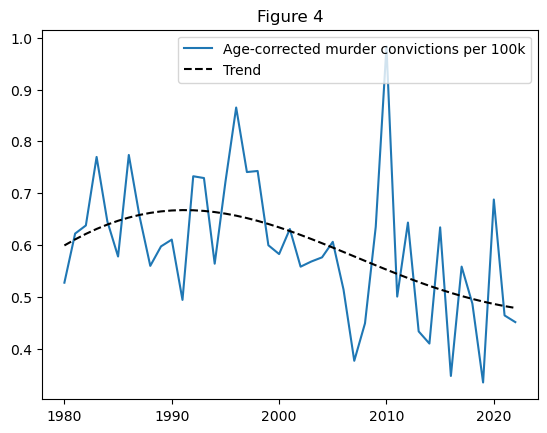

In [12]:
z2 = np.polyfit(tid1, mordrate3, 5) # fitting trend line
p2 = np.poly1d(z2)
fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)
ax2.plot(tid1, mordrate3, label='Age-corrected murder convictions per 100k')
ax2.plot(tid1, p2(tid1), color='black', linestyle='--', label='Trend')
plt.title('Figure 4')
plt.legend()
plt.show()

The result is similar to the non-corrected rates, but more muted. Importantly, the trend is not reversed by the correction. 
We remain convinced that the olden times were superior, so we run a simple regression to see if probability can explain the variation. 

In [13]:
tidreg = sm.add_constant(tid1)
model = sm.OLS(mordrate3, tidreg)
res = model.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.399
Date:                Tue, 23 May 2023   Prob (F-statistic):            0.00600
Time:                        19:24:16   Log-Likelihood:                 29.987
No. Observations:                  43   AIC:                            -55.97
Df Residuals:                      41   BIC:                            -52.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3878      3.034      3.094      0.0

#### Conclusion:
The relationship does not appear to be random. Perhaps Ye Olden Times were better in other ways. Yes, that's it. 